# VALIDATION OF THE SYNTHETIC NOISE DISTRIBUTIONS

**NOTE:** "B" version: added Wilcoxon-Mann-Whitley U and Kolmogorov-smirnov tests.

In this notebook we try to validate the concept used for noise generation in the synthetic samples, based on the real data.

In order to do that, we look at several correlations between the generated noise distributions and different parameters in the real source data, and also try to see how close are the ramnom values generated by the fitted distributions to the real values from which those fits were derived. 

## Modules and configuration

### Modules

In [80]:
import sys
import os
import pandas as pd
import numpy as np
import json

from IPython.display import clear_output

from scipy.stats import pearsonr, ttest_ind, normaltest, mannwhitneyu, kstest

from distfit import distfit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [81]:
GTO_FILE = "../data/SELECTION_for_ML_CARM_VIS_objects_with_PG.csv"
DIST_FILES_FOLDER = "../data/DIST_FILES/"
NOISE_DIST_FOLDER = "../data/DIST_FILES/RV_ML_subsample_Stars_noise_dist/"

RV_PATTERN_POOL_FILE = "RV_ML_subsample_sampling_patterns_and_noise_B.csv"

IMAGE_FOLDER = "./img/"

RANDOM_STATE = 11 # For reproducibility

N_TRIALS = 10 # Number of random noise samples to generate to test the goodness of fit.
ALPHA = 1e-3 # Significance threshold for statistical tests

### Functions

In [82]:
def noise_fit_goodness(source_data, fitted_dist, num_trials, src_min=None, src_max=None):
    '''Returns a median of the p-value for a given number of Kolmogorov-Smirnov and 
    Wilcoxon-Mann-Whitney U tests, calculated between a source data and a sample from
    a distribution fitted to that source data. Also return a median of the generated values
    that fall outside the range of the source data.'''
    
    # Code to silence output is from Alex Martelli and Nick T at:
    # https://stackoverflow.com/questions/2828953/silence-the-stdout-of-a-function-in-python-without-trashing-sys-stdout-and-resto
    # Redirect output to a file
    save_stdout = sys.stdout
    sys.stdout = open('trash', 'w')

    p_values = []
    oor_values = []
    if src_min is None:
        src_min = source_data.min()
    if src_max is None:
        src_max = source_data.max()
    for trial in range(0, num_trials):
        rnd_values = fitted_dist.generate(n=len(source_data), random_state=RANDOM_STATE)
        oor_fraction = (sum(rnd_values < src_min) + sum(rnd_values > src_max)) / len(rnd_values)
        oor_values.append(oor_fraction)
        #_, p = ttest_ind(source_data, rnd_values)
        _, ks_p = kstest(source_data, rnd_values)
        p_values.append(ks_p)
    
    # Redirect output to screen again, and delete the file.
    sys.stdout = save_stdout
    os.remove('trash')
    
    return np.nanmedian(p_values), np.nanmedian(oor_values)
    

In [83]:
def draw_boxplot(data, x, y, fig_title, x_label, y_label, hue=None, palette=None, order=None, showfliers=None, fig_filename=None):
    '''Draws a boxplot according to the arguments passed.'''
    # Plots and saves the figure
    #kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    sns.boxplot(data=data, x=x, y=y,
                hue=hue, palette=palette, order=order,
                showfliers=showfliers, dodge=False)
    plt.title(fig_title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    #plt.grid(axis='both', alpha=0.75)
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')


In [84]:
def scatter_graph(data, var_x, var_y, fig_title, x_label, y_label, fig_filename=None):
    '''Plots a scatter plot of two columns of a dataframe.
    It also calculates and shows Pearson's correlation coefficient.'''
    #rv_x_var = var_x
    #tess_y_var = var_y
    #kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    plt.title(fig_title, fontsize=16)
    #plt.grid(axis='both', alpha=0.75)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    sns.scatterplot(data=data, x=var_x, y=var_y)
#    plt.xlim(0.0, 1.0)
#    plt.ylim(0.0, 1.0)    
    plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Calculate the Pearson correlation coefficient between the two results:
    corr, _ = pearsonr(data[var_x], data[var_y])
    print('Pearson\'s correlation value: %.3f' % corr)

In [85]:
def draw_hist(d1, d1_label, fig_filename=None):
    '''Draws an histogram of the values passed. It also calulates the statistics
    and tests the goodness of fit by a Gaussian distribution'''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    plt.title(d1_label + " values distribution", fontsize=16)
    plt.grid(axis='both', alpha=0.75)
    plt.xlabel(d1_label, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    sns.distplot(d1, label=d1_label, **kwargs)
    #sns.histplot(d1, label=d1_label)
    #plt.xlim(0,100)
    #plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Display basic statistics:
    print(pd.Series(d1).describe())
    # Perform the normaltest (D'Agostino and Pearson) for Gaussian distribution fit:
    k2, p = normaltest(d1)
    alpha = ALPHA
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("***This distribution does NOT come from a Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))
    else:
        print("This distribution MIGHT COME come from Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))

## Load the RV patterns file

In [86]:
rv_patterns = pd.read_csv(DIST_FILES_FOLDER + RV_PATTERN_POOL_FILE, sep=',', decimal='.')
rv_patterns

,Karmn,Vr_kms-1,n_RV,Ps_RV,wrms_RV,RV_sampling_deltas,RV_noise_min,RV_noise_max,RV_noise_median,RV_noise_mean,RV_noise_stdev,RV_noise_dist,RV_noise_name,RV_noise_loc,RV_noise_scale,RV_noise_dist_file,RV_noise_fit_p-value,Fraction_Out
0,J23505-095,-21.870867,71.0,2.908164,3.362607,"[0.0, 11.957513123750687, 47.87879143701866, 5...",1.199479,4.170413,1.722917,1.881812,0.628702,{'distr': <scipy.stats._continuous_distns.t_ge...,t,1.691561,2.901930e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
1,J23492+024,-71.131000,373.0,1.143762,2.183867,"[0.0, 17.0164248123765, 190.38824744801968, 21...",0.951985,7.585994,1.517377,1.656111,0.599510,{'distr': <scipy.stats._continuous_distns.logn...,lognorm,0.862271,6.601781e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
2,J23431+365,-2.597000,23.0,17.057200,2.795865,"[0.0, 8.942367421463132, 9.875712749548256, 25...",0.916620,2.010952,1.377055,1.408319,0.262370,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,1.403768,2.331912e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
3,J23419+441,-77.764000,99.0,3.031857,2.532704,"[0.0, 136.37014811998233, 154.37618444254622, ...",0.829277,2.496016,1.297172,1.363447,0.307447,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.223698,2.125946e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
4,J23381-162,20.470749,56.0,3.019729,2.405056,"[0.0, 10.978803387377411, 30.955036497674882, ...",1.016080,3.446221,1.423674,1.611703,0.542434,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.343269,2.486426e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,J00184+440,10.997000,193.0,0.985929,2.311629,"[0.0, 13.990557200275362, 18.001077729277313, ...",0.832274,3.104075,1.331101,1.535932,0.554882,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,1.240303,3.236921e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
229,J00183+440,11.820000,216.0,0.826708,2.617721,"[0.0, 1.0492656417191029, 2.022110936231911, 3...",0.766382,4.264498,1.476962,1.556480,0.527647,{'distr': <scipy.stats._continuous_distns.beta...,beta,0.744054,7.930984e+00,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
230,J00162+198E,-1.625194,18.0,42.940403,2.861697,"[0.0, 15.97568494733423, 18.95287090772763, 18...",1.102225,2.145801,1.483359,1.577230,0.338830,{'distr': <scipy.stats._continuous_distns.beta...,beta,1.102225,1.076078e+00,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN
231,J00067-075,-40.123002,89.0,2.510671,2.440083,"[0.0, 0.9991974416188896, 11.033571805804968, ...",1.113746,5.291221,1.482946,1.572339,0.508195,{'distr': <scipy.stats._continuous_distns.beta...,beta,1.090486,1.083765e+13,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.0,NaN


### Add the number of cases of each distribution

In [33]:
rv_patterns['Occurrences'] = rv_patterns.groupby('RV_noise_name')['RV_noise_name'].transform('size')
rv_patterns.head()

,Karmn,Vr_kms-1,n_RV,Ps_RV,wrms_RV,RV_sampling_deltas,RV_noise_min,RV_noise_max,RV_noise_median,RV_noise_mean,RV_noise_stdev,RV_noise_dist,RV_noise_name,RV_noise_loc,RV_noise_scale,RV_noise_dist_file,RV_noise_fit_p-value,Fraction_Out,Occurrences
0,J23505-095,-21.870867,71.0,2.908164,3.362607,"[0.0, 11.957513123750687, 47.87879143701866, 5...",1.199479,4.170413,1.722917,1.881812,0.628702,{'distr': <scipy.stats._continuous_distns.t_ge...,t,1.691561,0.290193,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.103726,0.112676,25
1,J23492+024,-71.131000,373.0,1.143762,2.183867,"[0.0, 17.0164248123765, 190.38824744801968, 21...",0.951985,7.585994,1.517377,1.656111,0.599510,{'distr': <scipy.stats._continuous_distns.logn...,lognorm,0.862271,0.660178,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.490384,0.000000,32
2,J23431+365,-2.597000,23.0,17.057200,2.795865,"[0.0, 8.942367421463132, 9.875712749548256, 25...",0.916620,2.010952,1.377055,1.408319,0.262370,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,1.403768,0.233191,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.687567,0.043478,43
3,J23419+441,-77.764000,99.0,3.031857,2.532704,"[0.0, 136.37014811998233, 154.37618444254622, ...",0.829277,2.496016,1.297172,1.363447,0.307447,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.223698,0.212595,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.733246,0.000000,74
4,J23381-162,20.470749,56.0,3.019729,2.405056,"[0.0, 10.978803387377411, 30.955036497674882, ...",1.016080,3.446221,1.423674,1.611703,0.542434,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.343269,0.248643,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.482127,0.017857,74


In [34]:
dist_occurrences = rv_patterns[['RV_noise_name', 'Occurrences']] \
    .drop_duplicates().sort_values(by='Occurrences', ascending=False)
dist_occurrences

,RV_noise_name,Occurrences
3,genextreme,74
2,dweibull,43
1,lognorm,32
11,beta,32
0,t,25
10,gamma,17
23,expon,6
24,pareto,4


We also define an order to be used in the distributions plots.

In [35]:
dist_order = list(dist_occurrences['RV_noise_name'])
dist_order

['genextreme', 'dweibull', 'lognorm', 'beta', 't', 'gamma', 'expon', 'pareto']

In [36]:
reverse_dist_order = dist_order.copy()
reverse_dist_order.reverse()
reverse_dist_order

['pareto', 'expon', 'gamma', 't', 'beta', 'lognorm', 'dweibull', 'genextreme']

### Save the patterns with the occurrences value

In [37]:
rv_patterns.to_csv(DIST_FILES_FOLDER + RV_PATTERN_POOL_FILE, sep=',', decimal='.', index=False)

## Check correlations of noise distributions with other parameters

We will now check the correlations of the noise distributions and their main parameters `loc` (\~mean) and `scale` (\~standard deviation) with the other parameters of the RV curves.

In [38]:
rv_patterns.head()

,Karmn,Vr_kms-1,n_RV,Ps_RV,wrms_RV,RV_sampling_deltas,RV_noise_min,RV_noise_max,RV_noise_median,RV_noise_mean,RV_noise_stdev,RV_noise_dist,RV_noise_name,RV_noise_loc,RV_noise_scale,RV_noise_dist_file,RV_noise_fit_p-value,Fraction_Out,Occurrences
0,J23505-095,-21.870867,71.0,2.908164,3.362607,"[0.0, 11.957513123750687, 47.87879143701866, 5...",1.199479,4.170413,1.722917,1.881812,0.628702,{'distr': <scipy.stats._continuous_distns.t_ge...,t,1.691561,0.290193,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.103726,0.112676,25
1,J23492+024,-71.131000,373.0,1.143762,2.183867,"[0.0, 17.0164248123765, 190.38824744801968, 21...",0.951985,7.585994,1.517377,1.656111,0.599510,{'distr': <scipy.stats._continuous_distns.logn...,lognorm,0.862271,0.660178,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.490384,0.000000,32
2,J23431+365,-2.597000,23.0,17.057200,2.795865,"[0.0, 8.942367421463132, 9.875712749548256, 25...",0.916620,2.010952,1.377055,1.408319,0.262370,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,1.403768,0.233191,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.687567,0.043478,43
3,J23419+441,-77.764000,99.0,3.031857,2.532704,"[0.0, 136.37014811998233, 154.37618444254622, ...",0.829277,2.496016,1.297172,1.363447,0.307447,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.223698,0.212595,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.733246,0.000000,74
4,J23381-162,20.470749,56.0,3.019729,2.405056,"[0.0, 10.978803387377411, 30.955036497674882, ...",1.016080,3.446221,1.423674,1.611703,0.542434,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.343269,0.248643,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.482127,0.017857,74


### Search for correlations of noise distribution type 

#### Noise distributions vs radial velocity of the star

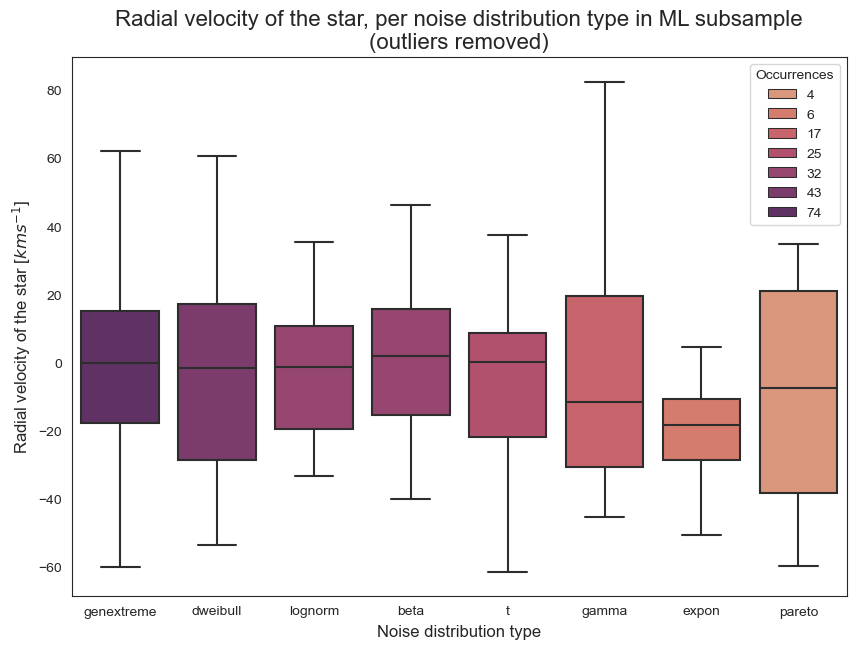

In [39]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='Vr_kms-1', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Radial velocity of the star, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="Radial velocity of the star [$kms^{-1}$]",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_01_RadialVelocity_vs_NoiseDist.jpg")

**OBSERVATION:** no clear correlation is seen.

#### Noise distributions vs number of RV data points

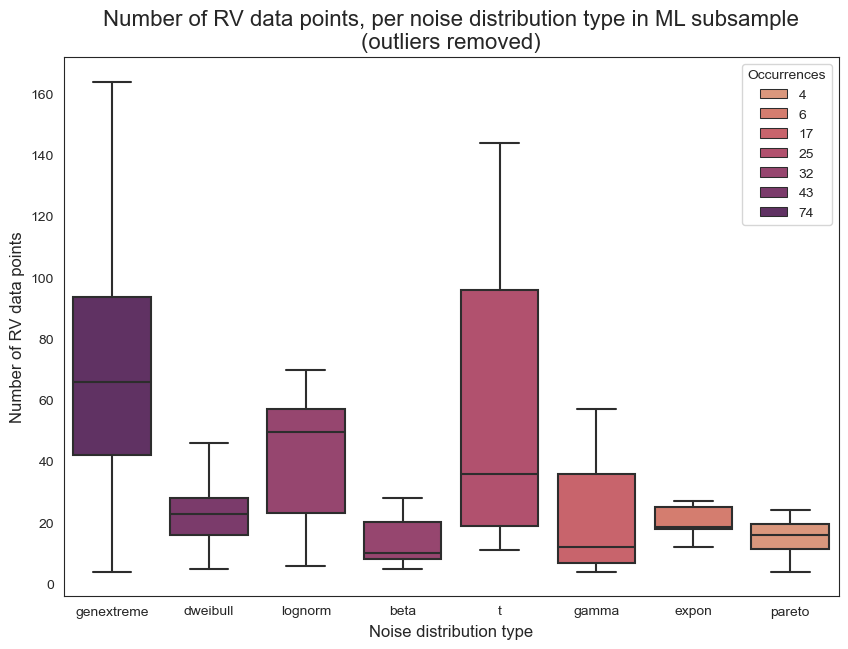

In [40]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='n_RV', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Number of RV data points, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="Number of RV data points",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_02_NumberPoints_vs_NoiseDist.jpg")

**OBSERVATION:** no clear correlation is seen.

#### Noise distributions vs average sampling period

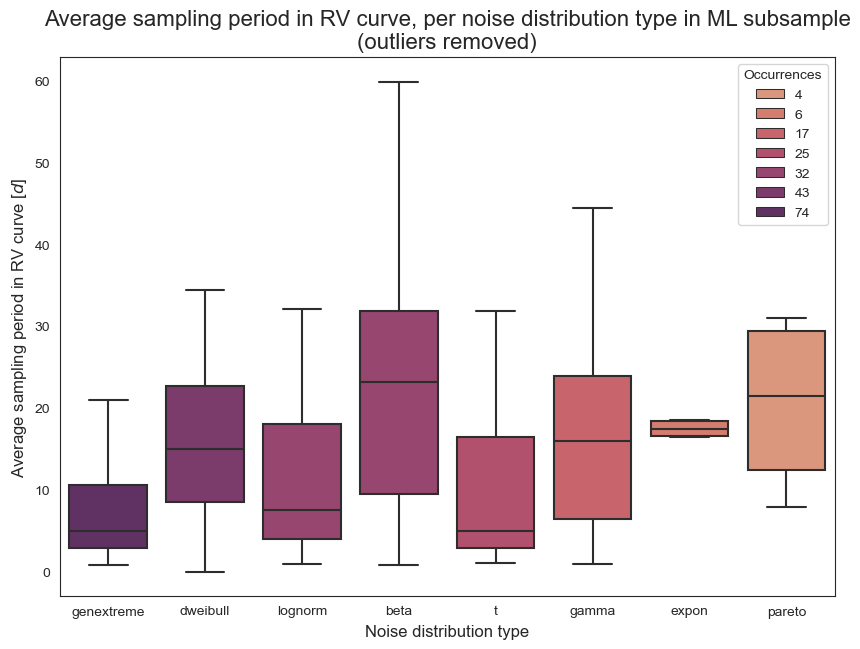

In [41]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='Ps_RV', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Average sampling period in RV curve, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="Average sampling period in RV curve [$d$]",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_03_SamplingPeriod_vs_NoiseDist.jpg")

**OBSERVATION:** no clear correlation is seen.

#### Noise distributions vs RMS values in RV curve

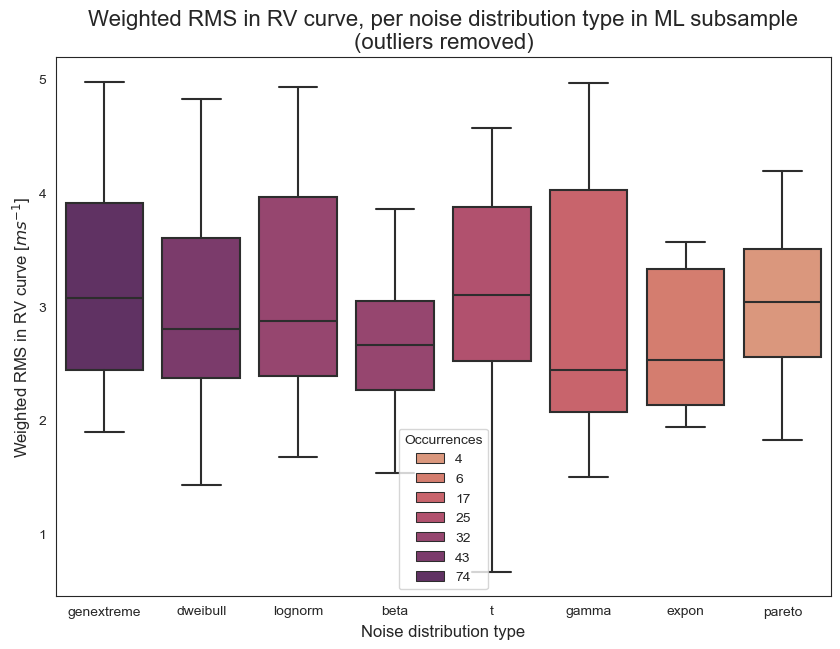

In [42]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='wrms_RV', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Weighted RMS in RV curve, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="Weighted RMS in RV curve [$ms^{-1}$]",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_04_RVRMS_vs_NoiseDist.jpg")

**OBSERVATION:** no clear correlation is seen.

#### Noise distributions vs median error in RV curves

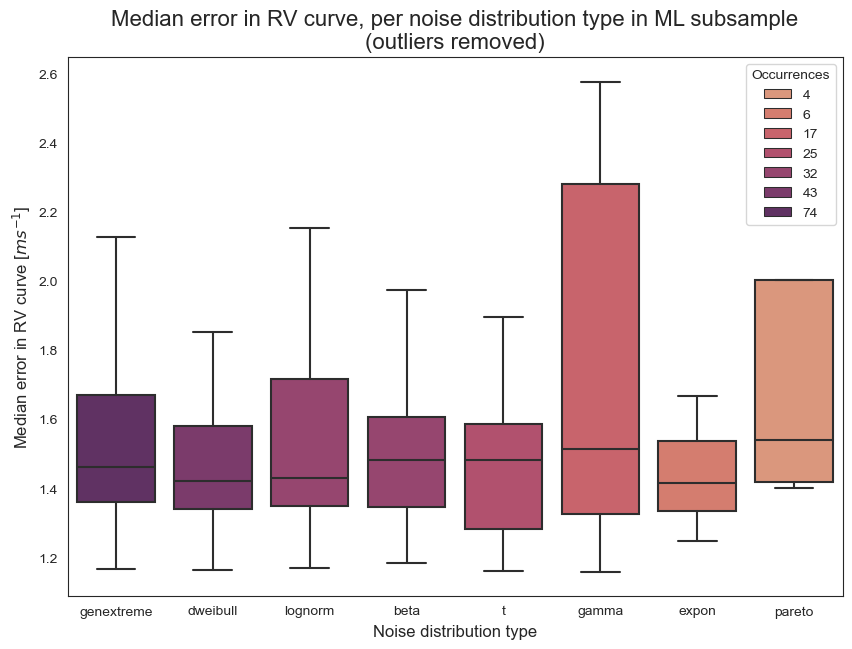

In [47]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='RV_noise_median', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Median error in RV curve, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="Median error in RV curve [$ms^{-1}$]",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_05_ErrorMedian_vs_NoiseDist.jpg")

**OBSERVATION:** no clear correlation is seen.

#### Noise distributions vs mean error in RV curves

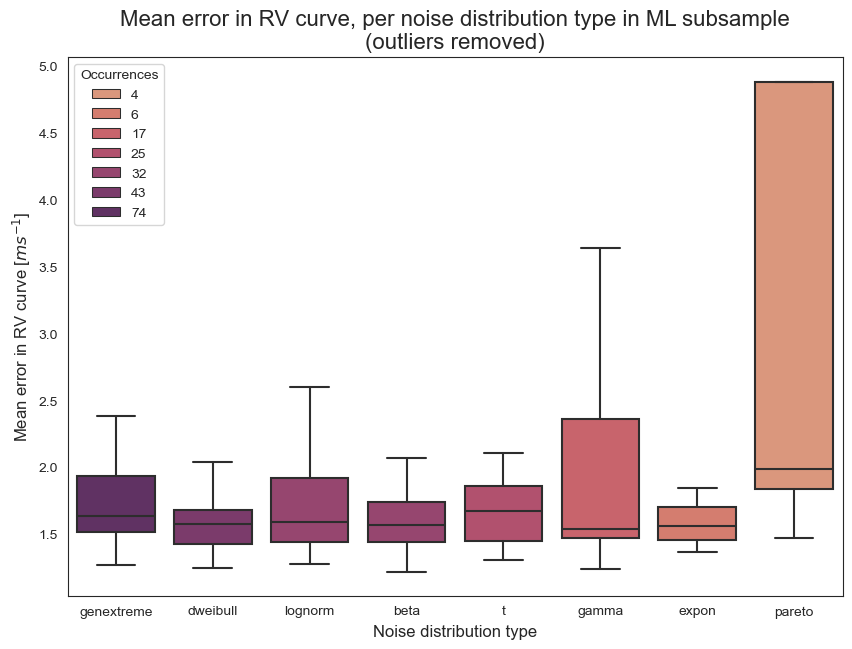

In [48]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='RV_noise_mean', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Mean error in RV curve, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="Mean error in RV curve [$ms^{-1}$]",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_06_ErrorMean_vs_NoiseDist.jpg")

**OBSERVATION:** pareto distribution seems clearly more prone to have large mean error values, but the number of occurrences of such distribution is too small to be of significance.

#### Noise distributions vs standard deviation of errors in RV curves

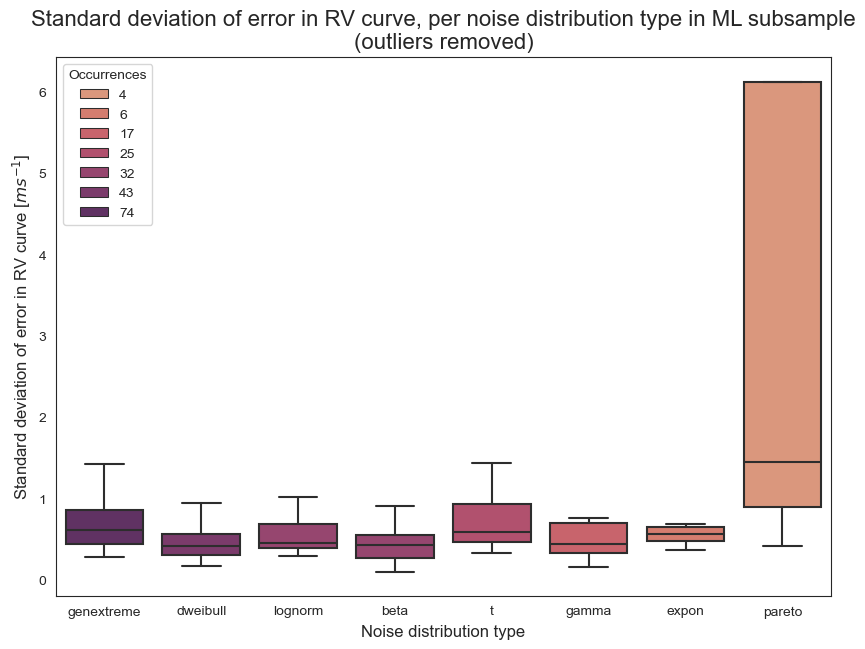

In [49]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='RV_noise_stdev', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Standard deviation of error in RV curve, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="Standard deviation of error in RV curve [$ms^{-1}$]",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_07_ErrorStdev_vs_NoiseDist.jpg")

**OBSERVATION:** again, only pareto distribution (not very common) is clearly different from the other distributions.

### Search for correlations of noise `loc` (\~mean) 

In [50]:
print(sorted(list(rv_patterns['RV_noise_loc'])))

[-0.532584477469382, -0.1760352424839806, -0.0032938306939351, -0.0020198059455861, 0.6750215798808036, 0.7440544205442312, 0.7494809912681801, 0.771173590590023, 0.7744371523342763, 0.7959381582785001, 0.8389080128624955, 0.8411535393645131, 0.8622705300426897, 0.868744198555389, 0.88250315544502, 0.8830891626059911, 0.8912541913810335, 0.9073017392164592, 0.9109042725683314, 0.9148822993616934, 0.9152026923365524, 0.9290654136003658, 0.929740758359784, 0.9402121957165736, 0.9425328396533572, 0.9458987519876773, 0.9485689216836344, 0.9554393519780072, 0.961670589884616, 0.9633360370451572, 0.969842663866854, 0.9748003005239876, 0.974812500068962, 0.9785201484287704, 0.9810212185037142, 0.9882040557789692, 0.989892110062244, 0.9985298815660266, 0.9994417637548132, 1.0031794877028373, 1.0074379809452312, 1.0099871188219385, 1.0169198318658448, 1.0262751913457084, 1.0325298093521769, 1.035237441974626, 1.0394161152298973, 1.0395117808295105, 1.0521931585609328, 1.0524657138904756, 1.0550

**Note:** we will discard in this case the values below 0.0 and the last value of $\approx6\;ms^{-1}$.

#### Noise `loc` (\~mean) vs radial velocity of the star

**Note:** it was necessary to drop the `NaN`values, because for 3 starts we did not have radial velocity data.

In [51]:
rv_patterns[rv_patterns['Vr_kms-1'].isna()]

,Karmn,Vr_kms-1,n_RV,Ps_RV,wrms_RV,RV_sampling_deltas,RV_noise_min,RV_noise_max,RV_noise_median,RV_noise_mean,RV_noise_stdev,RV_noise_dist,RV_noise_name,RV_noise_loc,RV_noise_scale,RV_noise_dist_file,RV_noise_fit_p-value,Fraction_Out,Occurrences
137,J10238+438,NaN,5.0,76.459345,3.193724,"[0.0, 29.9763525580056, 228.2638283399865, 308...",1.576673,3.472824,2.055156,2.449492,0.715615,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,2.055156,0.918968,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.978250,0.4,43
205,J02573+765,NaN,57.0,1.006746,3.685257,"[0.0, 3.9277518554590642, 4.923314188141376, 5...",1.474246,5.016125,2.576642,2.703577,0.762145,{'distr': <scipy.stats._continuous_distns.gamm...,gamma,1.319674,0.439530,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.665456,0.0,17
216,J01550+379,NaN,4.0,30.958546,4.537402,"[0.0, 31.086602435912937, 61.041602172888815, ...",2.062424,6.474123,2.281311,3.274792,1.851650,{'distr': <scipy.stats._continuous_distns.gamm...,gamma,2.062424,0.857145,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.323012,0.0,17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.032


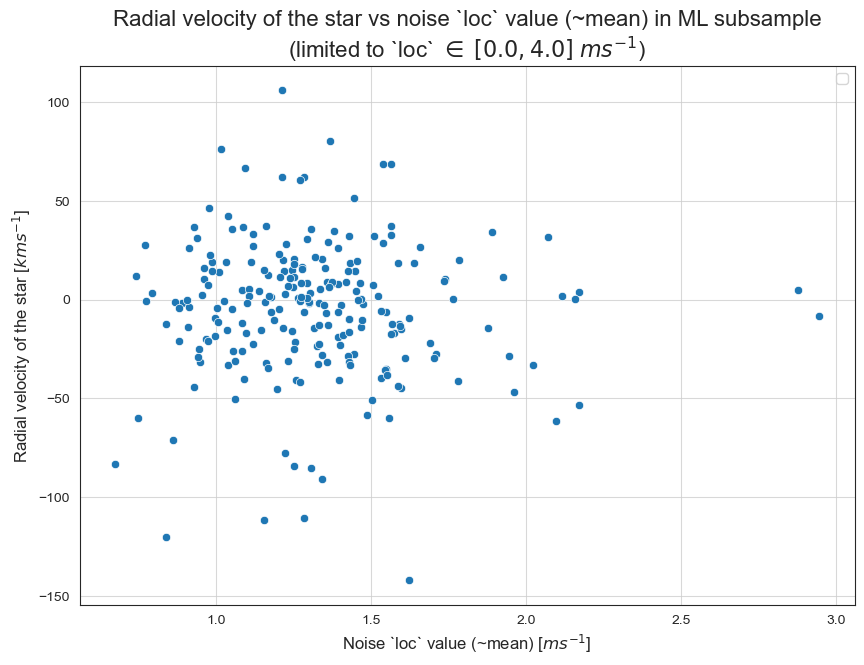

In [52]:
scatter_graph(data=rv_patterns[(rv_patterns['RV_noise_loc'] > 0.0) & (rv_patterns['RV_noise_loc'] < 4.0)].dropna(),
              var_x='RV_noise_loc', var_y='Vr_kms-1',
              fig_title="Radial velocity of the star vs noise `loc` value (~mean) in ML subsample\n" \
              "(limited to `loc` $\in\;[0.0, 4.0]\;ms^{-1}$)",
              x_label="Noise `loc` value (~mean) [$ms^{-1}$]",
              y_label="Radial velocity of the star [$kms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_08_RadialVelocity_vs_Noise_loc.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Noise `loc` (\~mean) vs number of RV data points

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.043


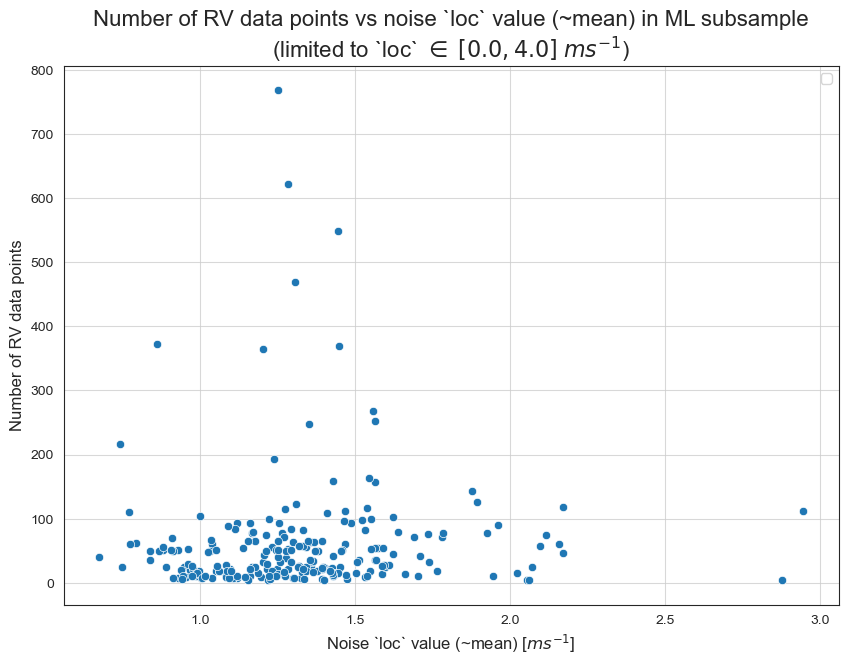

In [53]:
scatter_graph(data=rv_patterns[(rv_patterns['RV_noise_loc'] > 0.0) & (rv_patterns['RV_noise_loc'] < 4.0)],
              var_x='RV_noise_loc', var_y='n_RV',
              fig_title="Number of RV data points vs noise `loc` value (~mean) in ML subsample\n" \
              "(limited to `loc` $\in\;[0.0, 4.0]\;ms^{-1}$)",
              x_label="Noise `loc` value (~mean) [$ms^{-1}$]",
              y_label="Number of RV data points",
              fig_filename=IMAGE_FOLDER + "SD_14_09_NumberPoints_vs_Noise_loc.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Noise `loc` (\~mean) vs average sampling period

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.103


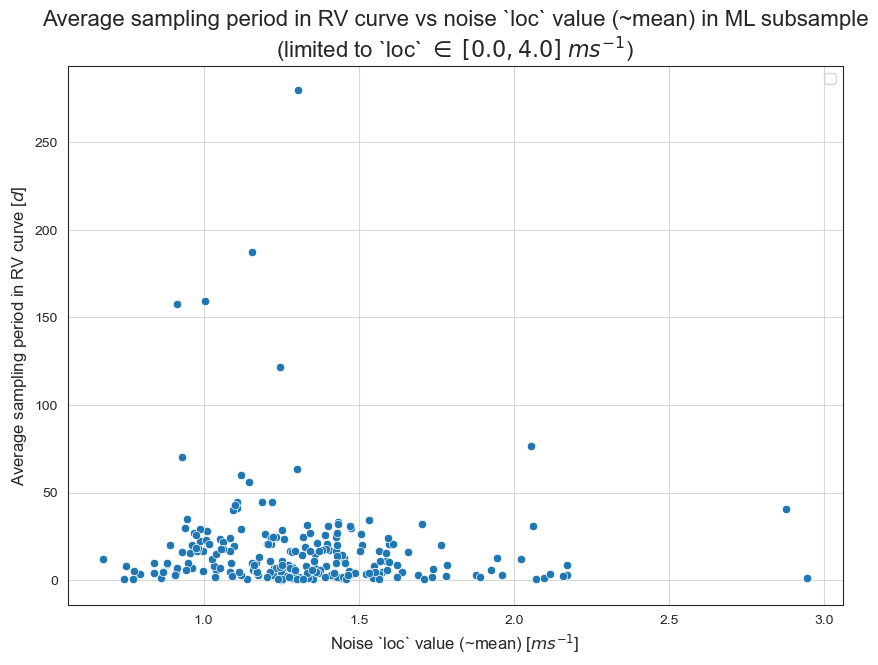

In [54]:
scatter_graph(data=rv_patterns[(rv_patterns['RV_noise_loc'] > 0.0) & (rv_patterns['RV_noise_loc'] < 4.0)],
              var_x='RV_noise_loc', var_y='Ps_RV',
              fig_title="Average sampling period in RV curve vs noise `loc` value (~mean) in ML subsample\n" \
              "(limited to `loc` $\in\;[0.0, 4.0]\;ms^{-1}$)",
              x_label="Noise `loc` value (~mean) [$ms^{-1}$]",
              y_label="Average sampling period in RV curve [$d$]",
              fig_filename=IMAGE_FOLDER + "SD_14_10_SamplingPeriod_vs_Noise_loc.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Noise `loc` (\~mean) vs RMS values in RV curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.431


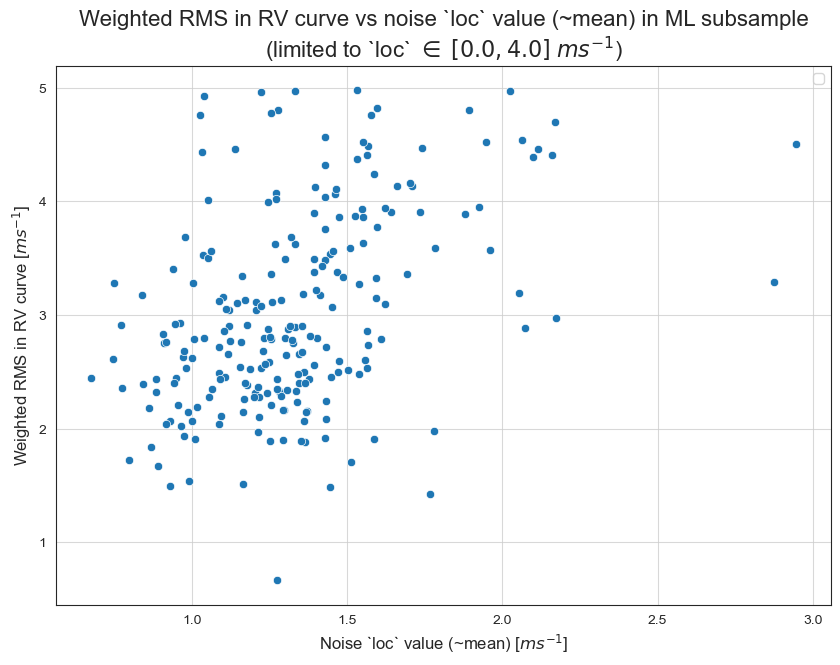

In [55]:
scatter_graph(data=rv_patterns[(rv_patterns['RV_noise_loc'] > 0.0) & (rv_patterns['RV_noise_loc'] < 4.0)],
              var_x='RV_noise_loc', var_y='wrms_RV',
              fig_title="Weighted RMS in RV curve vs noise `loc` value (~mean) in ML subsample\n" \
              "(limited to `loc` $\in\;[0.0, 4.0]\;ms^{-1}$)",
              x_label="Noise `loc` value (~mean) [$ms^{-1}$]",
              y_label="Weighted RMS in RV curve [$ms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_11_RVRMS_vs_Noise_loc.jpg")

**OBSERVATION:** in this case some kind of correlation can be observed inm the plot, confirmed by a relatively high value of Pearson's correlation coefficient. However, the cloud of points is pretty sparse, and the correlation value is not that high at 0.431, so we will also consider this result as "no correlation". 

### Search for correlations of noise `scale` (\~standard deviation) 

In [56]:
print(sorted(list(rv_patterns['RV_noise_scale'])))

[0.0072203838263716, 0.0075373850824914, 0.0173647204356535, 0.0474351130164185, 0.0959505440464062, 0.1031445444011439, 0.1052806999979943, 0.1215215106119023, 0.125418208084833, 0.1305667491631262, 0.1362755821896573, 0.1473967574302482, 0.1497269286345781, 0.1534298134100191, 0.1562721744326246, 0.1591450275884716, 0.1593410149664731, 0.1639447380408726, 0.1734739816217745, 0.174712016766984, 0.1753399719532331, 0.1828591261734196, 0.1841244096088116, 0.1946287090106089, 0.1952685987660952, 0.1964213623143029, 0.1964799651286104, 0.1985627804884572, 0.201656874612423, 0.2027886740610679, 0.2030702144236069, 0.2076179412639122, 0.2083633973199828, 0.2090689261543991, 0.2111035267066192, 0.211117569021396, 0.2119517072329079, 0.2120333367276436, 0.2125946347255921, 0.2150710089628051, 0.2237212839511999, 0.2238901542817371, 0.2264487601547703, 0.2270370839001941, 0.2275600619322847, 0.2283413121206945, 0.2323003106925374, 0.2331911936837903, 0.2352456534289977, 0.2361947000842164, 0.2

**Note:** we see that the last 3 values are clearly outliers. We will discard the four last values to (we will set a limit at $30.0\;ms^{-1}$).

#### Noise `scale` (\~standard deviation) vs radial velocity of the star

**Note:** it was necessary to drop the `NaN`values, because for 3 starts we did not have radial velocity data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.062


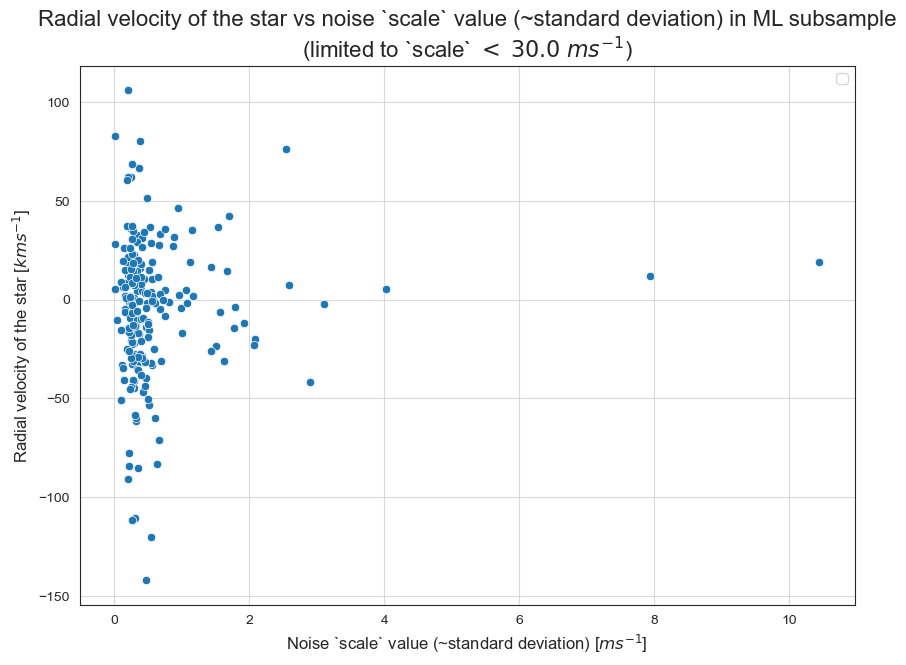

In [57]:
scatter_graph(data=rv_patterns[rv_patterns['RV_noise_scale'] < 30.0].dropna(),
              var_x='RV_noise_scale', var_y='Vr_kms-1',
              fig_title="Radial velocity of the star vs noise `scale` value (~standard deviation) in ML subsample\n" \
              "(limited to `scale` $<\;30.0\;ms^{-1}$)",
              x_label="Noise `scale` value (~standard deviation) [$ms^{-1}$]",
              y_label="Radial velocity of the star [$kms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_12_RadialVelocity_vs_Noise_scale.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Noise `scale` (\~standard deviation) vs number of RV data points

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.054


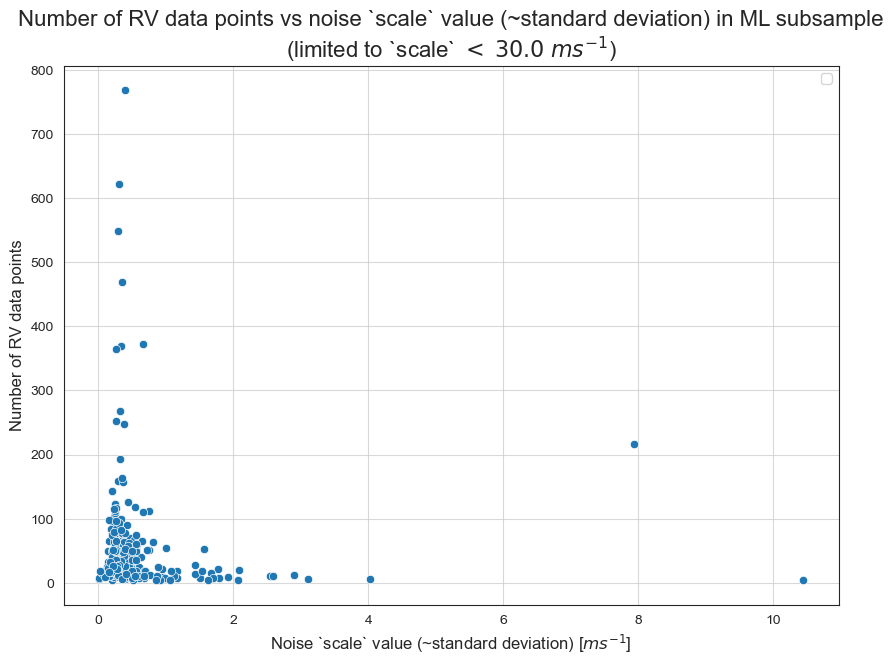

In [58]:
scatter_graph(data=rv_patterns[rv_patterns['RV_noise_scale'] < 30.0],
              var_x='RV_noise_scale', var_y='n_RV',
              fig_title="Number of RV data points vs noise `scale` value (~standard deviation) in ML subsample\n" \
              "(limited to `scale` $<\;30.0\;ms^{-1}$)",
              x_label="Noise `scale` value (~standard deviation) [$ms^{-1}$]",
              y_label="Number of RV data points",
              fig_filename=IMAGE_FOLDER + "SD_14_13_NumberPoints_vs_Noise_scale.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Noise `scale` (\~standard deviation) vs average sampling period

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.025


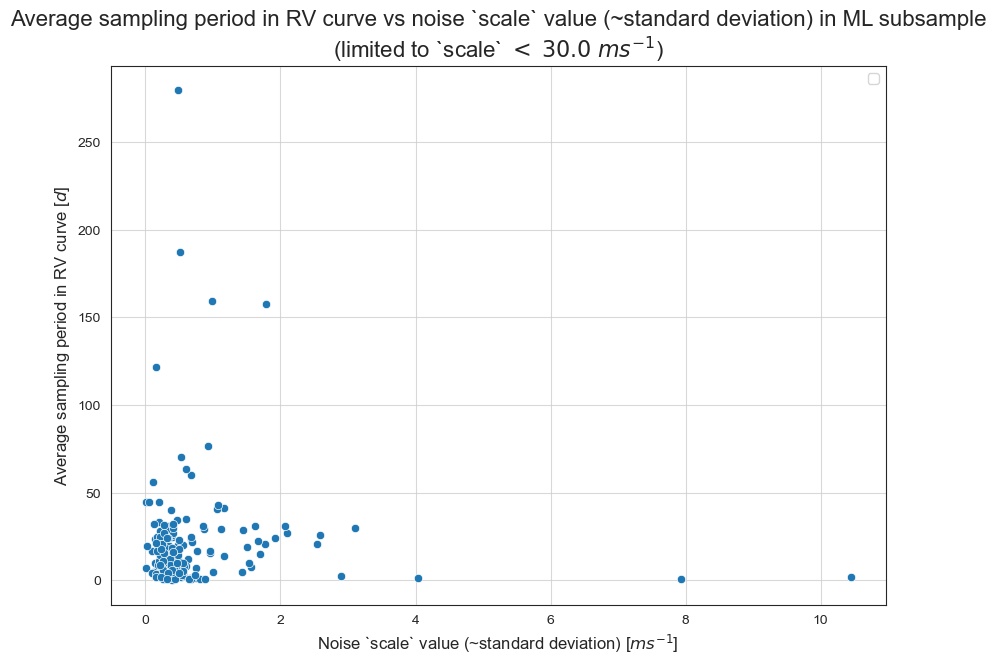

In [59]:
scatter_graph(data=rv_patterns[rv_patterns['RV_noise_scale'] < 30.0],
              var_x='RV_noise_scale', var_y='Ps_RV',
              fig_title="Average sampling period in RV curve vs noise `scale` value (~standard deviation) in ML subsample\n" \
              "(limited to `scale` $<\;30.0\;ms^{-1}$)",
              x_label="Noise `scale` value (~standard deviation) [$ms^{-1}$]",
              y_label="Average sampling period in RV curve [$d$]",
              fig_filename=IMAGE_FOLDER + "SD_14_14_SamplingPeriod_vs_Noise_scale.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Noise `scale` (\~standard deviation) vs RMS values in RV curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.046


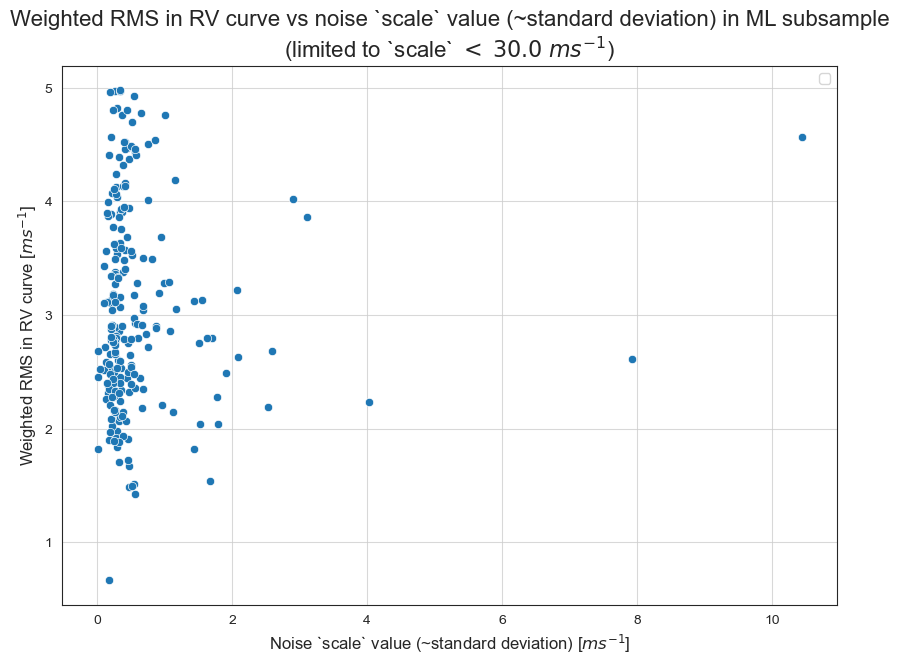

In [60]:
scatter_graph(data=rv_patterns[rv_patterns['RV_noise_scale'] < 30.0],
              var_x='RV_noise_scale', var_y='wrms_RV',
              fig_title="Weighted RMS in RV curve vs noise `scale` value (~standard deviation) in ML subsample\n" \
              "(limited to `scale` $<\;30.0\;ms^{-1}$)",
              x_label="Noise `scale` value (~standard deviation) [$ms^{-1}$]",
              y_label="Weighted RMS in RV curve [$ms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_15_RVRMS_vs_Noise_scale.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

### Search for correlations of median error

In [61]:
print(sorted(list(rv_patterns['RV_noise_median'])))

[1.159783648150292, 1.1616542890649098, 1.1634774414257365, 1.1668353372643754, 1.1716816254014115, 1.1781472832464557, 1.185700275778079, 1.2033921209176202, 1.2045775051369976, 1.2134350492441848, 1.2218253912610222, 1.2223350224961318, 1.2245004390944771, 1.226739798657705, 1.2352493399528477, 1.236676898906491, 1.2429384474215417, 1.2448788440058132, 1.2498785606179703, 1.251464491032216, 1.2523206169821748, 1.252393416644257, 1.2550747187420843, 1.2573182271397385, 1.2583406971890256, 1.2594384984584086, 1.2669421405992454, 1.2672596513095802, 1.2678376005535834, 1.2736236089003423, 1.2821094264580042, 1.2836498716079194, 1.2873233409173213, 1.2904725036931284, 1.2922221565136354, 1.297171518544158, 1.2991164320913884, 1.3010679475934677, 1.3066515637229406, 1.3082793626211449, 1.3113380536044608, 1.311884902858274, 1.312505819043596, 1.3167508922580902, 1.3175221954230878, 1.3181340363465002, 1.3196272201770227, 1.31985180835435, 1.3232464954743297, 1.323362526779828, 1.323794548

**Note:** we see that the last 3 values are clearly outliers. We will discard the four last values to (we will set a limit at $30.0\;ms^{-1}$).

#### Median error vs radial velocity of the star

**Note:** it was necessary to drop the `NaN`values, because for 3 starts we did not have radial velocity data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.019


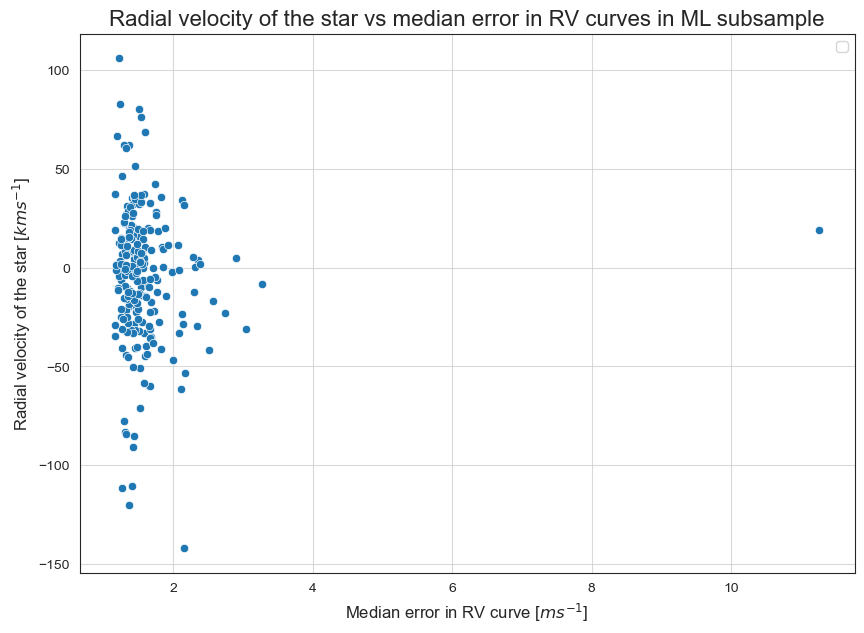

In [62]:
scatter_graph(data=rv_patterns.dropna(),
              var_x='RV_noise_median', var_y='Vr_kms-1',
              fig_title="Radial velocity of the star vs median error in RV curves in ML subsample",
              x_label="Median error in RV curve [$ms^{-1}$]",
              y_label="Radial velocity of the star [$kms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_16_RadialVelocity_vs_ErrorMedian.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Median error vs number of RV data points

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.045


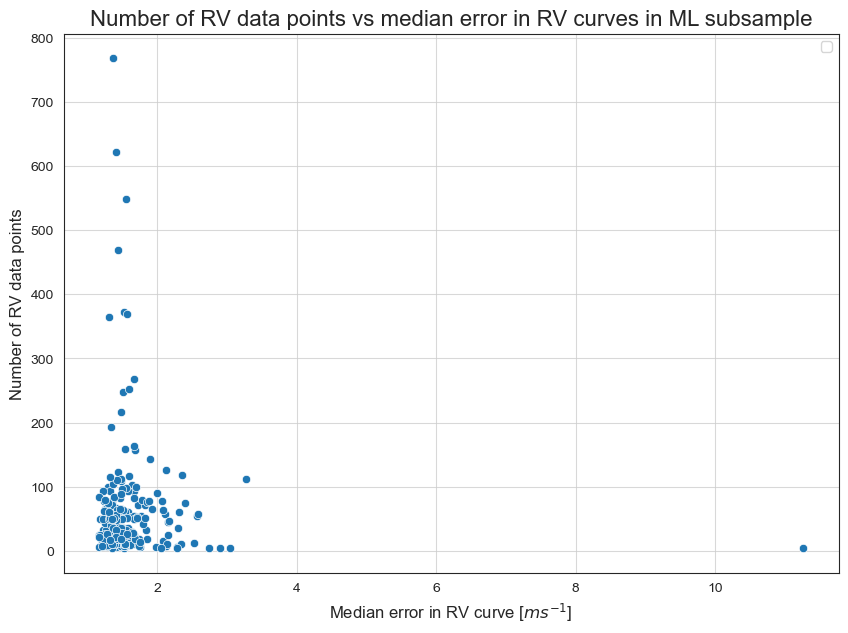

In [63]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_median', var_y='n_RV',
              fig_title="Number of RV data points vs median error in RV curves in ML subsample",
              x_label="Median error in RV curve [$ms^{-1}$]",
              y_label="Number of RV data points",
              fig_filename=IMAGE_FOLDER + "SD_14_17_NumberPoints_vs_ErrorMedian.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Median error vs average sampling period

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.076


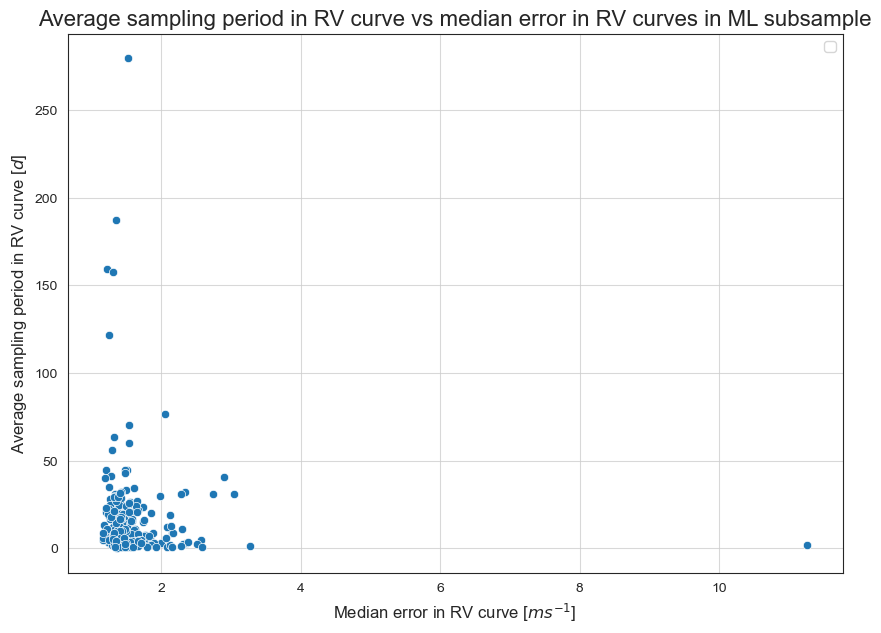

In [64]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_median', var_y='Ps_RV',
              fig_title="Average sampling period in RV curve vs median error in RV curves in ML subsample",
              x_label="Median error in RV curve [$ms^{-1}$]",
              y_label="Average sampling period in RV curve [$d$]",
              fig_filename=IMAGE_FOLDER + "SD_14_18_SamplingPeriod_vs_ErrorMedian.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

####  Median error vs RMS values in RV curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.306


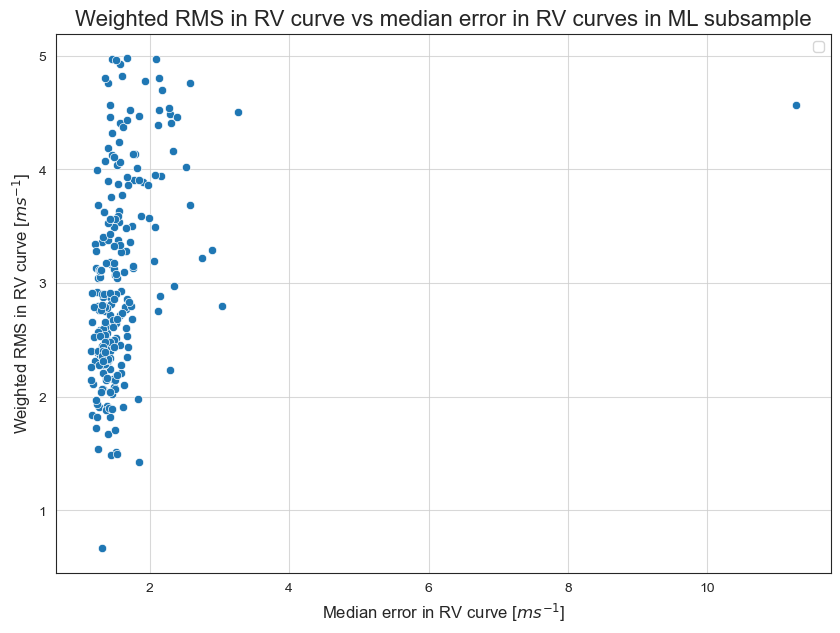

In [65]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_median', var_y='wrms_RV',
              fig_title="Weighted RMS in RV curve vs median error in RV curves in ML subsample",
              x_label="Median error in RV curve [$ms^{-1}$]",
              y_label="Weighted RMS in RV curve [$ms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_19_RVRMS_vs_ErrorMedian.jpg")

**OBSERVATION:** no clear correlation is seen. The Pearson's coefficient value, though, is slightly greater than in previous cases.

### Search for correlations of mean error

In [66]:
print(sorted(list(rv_patterns['RV_noise_mean'])))

[1.220362941269753, 1.2314049129673514, 1.2403063541612624, 1.2512755678176388, 1.267102294927508, 1.269970581768009, 1.2699901881218223, 1.2769817392500649, 1.2936260621280429, 1.306724446740307, 1.3129435856656864, 1.3211615647626076, 1.3253216142440905, 1.3276980626862365, 1.3585819931786671, 1.3589801243194437, 1.3604583957301188, 1.3634470346126586, 1.3639047303980054, 1.3646235997018716, 1.365189365663274, 1.375758257282411, 1.376476073490951, 1.3765248992970067, 1.3812969055547617, 1.383962590735668, 1.3880971092509178, 1.3913834080145828, 1.3976786319782482, 1.399281231953178, 1.3994034059217657, 1.404883757408486, 1.4054015999973273, 1.4080243893311963, 1.4083185618684908, 1.4114913709698145, 1.412597008662596, 1.4132842268173174, 1.4168145490985995, 1.4172182180837876, 1.4174021917070172, 1.418909805069574, 1.4256439286678786, 1.4285149090128284, 1.429370537336336, 1.4319932354699498, 1.4329825859909946, 1.434956117853757, 1.4456488239250596, 1.4477719207387003, 1.44890930931

**Note:** we see that the last 3 values are clearly outliers. We will discard the four last values to (we will set a limit at $30.0\;ms^{-1}$).

#### Mean error vs radial velocity of the star

**Note:** it was necessary to drop the `NaN`values, because for 3 starts we did not have radial velocity data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.043


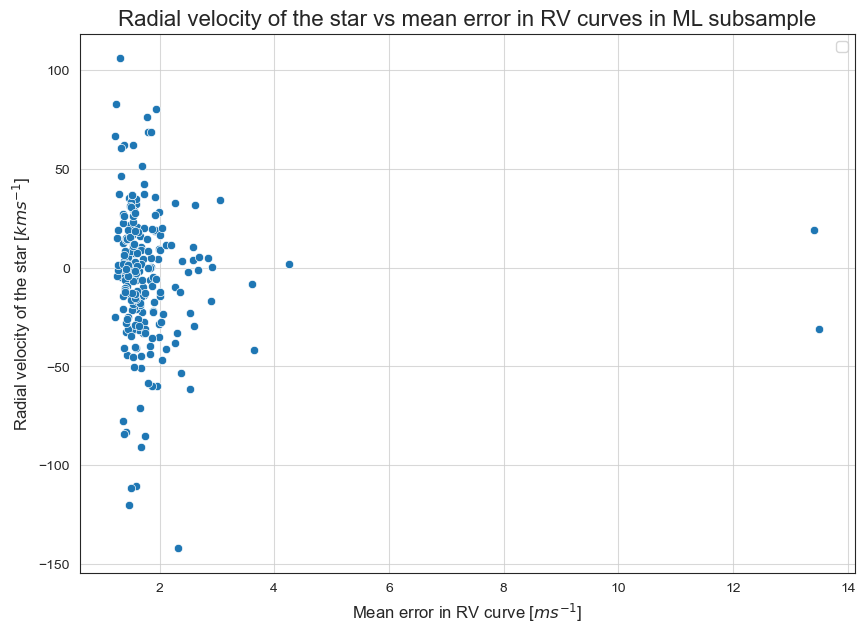

In [67]:
scatter_graph(data=rv_patterns.dropna(),
              var_x='RV_noise_mean', var_y='Vr_kms-1',
              fig_title="Radial velocity of the star vs mean error in RV curves in ML subsample",
              x_label="Mean error in RV curve [$ms^{-1}$]",
              y_label="Radial velocity of the star [$kms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_20_RadialVelocity_vs_ErrorMean.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Mean error vs number of RV data points

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.043


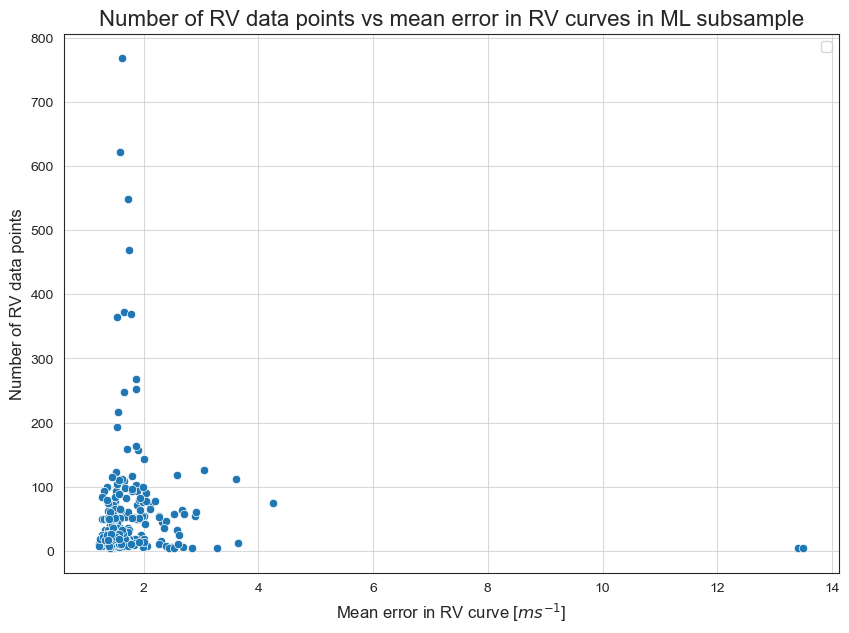

In [68]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_mean', var_y='n_RV',
              fig_title="Number of RV data points vs mean error in RV curves in ML subsample",
              x_label="Mean error in RV curve [$ms^{-1}$]",
              y_label="Number of RV data points",
              fig_filename=IMAGE_FOLDER + "SD_14_21_NumberPoints_vs_ErrorMean.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Mean error vs average sampling period

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.031


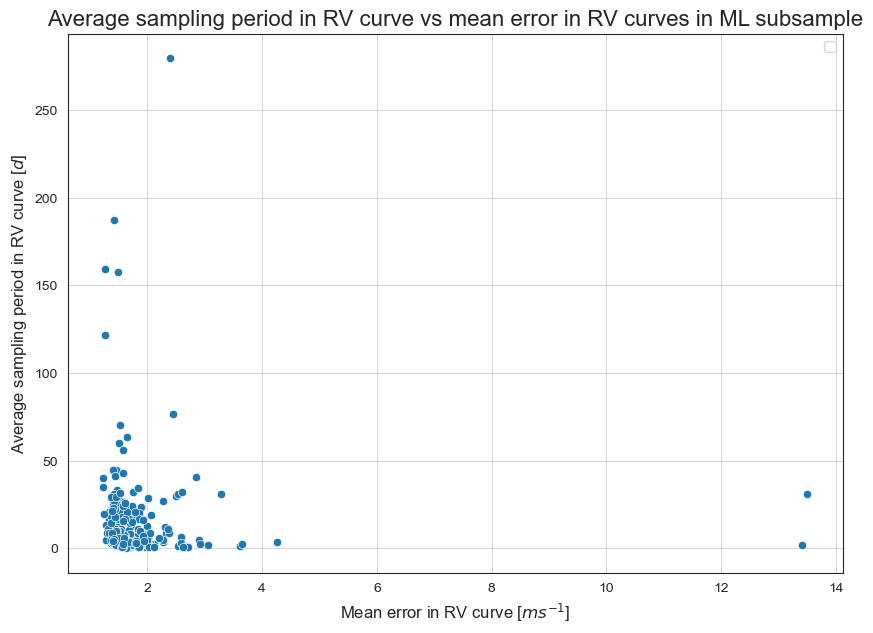

In [69]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_mean', var_y='Ps_RV',
              fig_title="Average sampling period in RV curve vs mean error in RV curves in ML subsample",
              x_label="Mean error in RV curve [$ms^{-1}$]",
              y_label="Average sampling period in RV curve [$d$]",
              fig_filename=IMAGE_FOLDER + "SD_14_22_SamplingPeriod_vs_ErrorMean.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

####  Mean error vs RMS values in RV curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.237


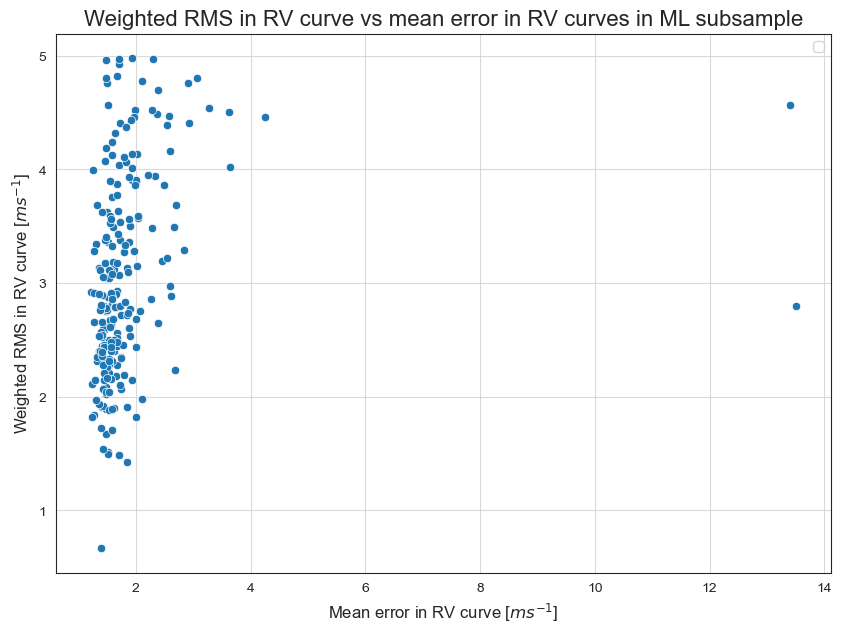

In [70]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_mean', var_y='wrms_RV',
              fig_title="Weighted RMS in RV curve vs mean error in RV curves in ML subsample",
              x_label="Mean error in RV curve [$ms^{-1}$]",
              y_label="Weighted RMS in RV curve [$ms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_23_RVRMS_vs_ErrorMean.jpg")

**OBSERVATION:** again, no clear correlation is seen, although the Pearson's coefficient value is again greater than that for other variables.

### Search for correlations of standard deviation of errors

In [71]:
print(sorted(list(rv_patterns['RV_noise_stdev'])))

[0.1026745079621104, 0.1566926518179859, 0.1728518021534325, 0.175149010339733, 0.1912751288137201, 0.1943237777610126, 0.2023911700655074, 0.205988812911813, 0.2138403093696793, 0.2150210385362847, 0.2303325482955568, 0.2371773083194545, 0.2395415002283453, 0.2432261073766302, 0.2522908057292959, 0.2623699816960665, 0.2766647490604501, 0.2813457483096276, 0.2821268005350873, 0.2868829737160105, 0.2934034899292447, 0.2996259222541705, 0.3058766972466341, 0.3074469286126199, 0.3075026312664414, 0.3093177942941871, 0.31016067643292, 0.3133571090605208, 0.3156684866407368, 0.317982291823574, 0.3180642424701703, 0.3198724924251434, 0.325947075772661, 0.3294184068387236, 0.3312145827974265, 0.3329352383758913, 0.3332498364153981, 0.3343593953494241, 0.3347820980131641, 0.3379555903536533, 0.3388298787878328, 0.3423733041237253, 0.3434216244744095, 0.3444995448097297, 0.3451856213647371, 0.3517739731538302, 0.3587322889818049, 0.3598614188511519, 0.3644684556100051, 0.3656345242300843, 0.372

**Note:** we see that the last 3 values are clearly outliers. We will discard the four last values to (we will set a limit at $30.0\;ms^{-1}$).

#### Standard deviation of error vs radial velocity of the star

**Note:** it was necessary to drop the `NaN`values, because for 3 starts we did not have radial velocity data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.025


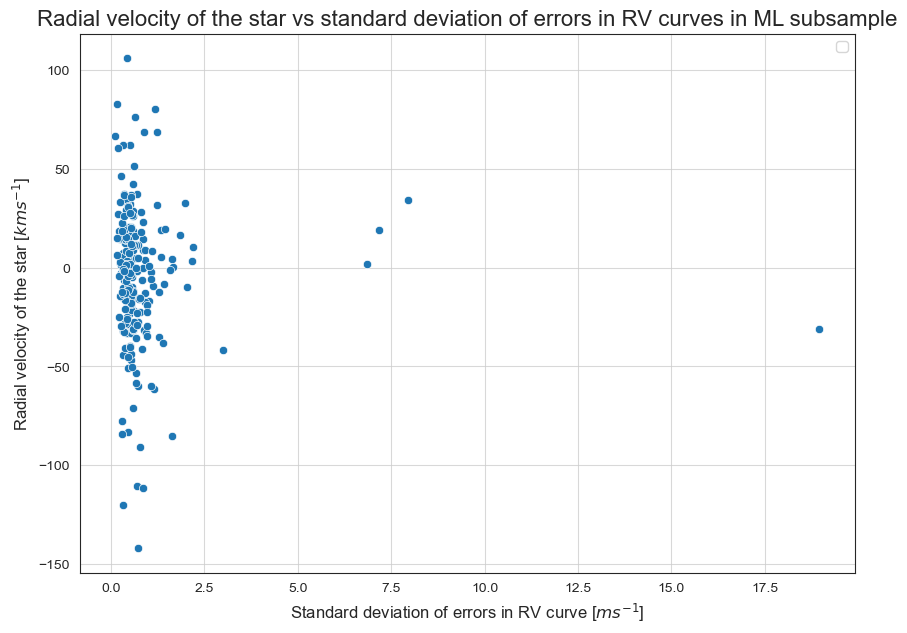

In [72]:
scatter_graph(data=rv_patterns.dropna(),
              var_x='RV_noise_stdev', var_y='Vr_kms-1',
              fig_title="Radial velocity of the star vs standard deviation of errors in RV curves in ML subsample",
              x_label="Standard deviation of errors in RV curve [$ms^{-1}$]",
              y_label="Radial velocity of the star [$kms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_24_RadialVelocity_vs_ErrorStdev.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Standard deviation of error vs number of RV data points

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.012


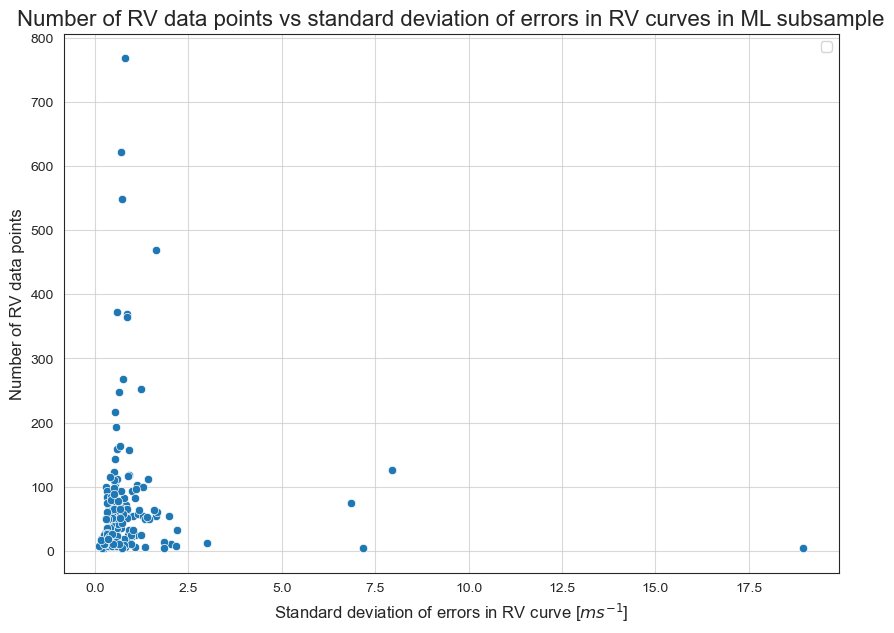

In [73]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_stdev', var_y='n_RV',
              fig_title="Number of RV data points vs standard deviation of errors in RV curves in ML subsample",
              x_label="Standard deviation of errors in RV curve [$ms^{-1}$]",
              y_label="Number of RV data points",
              fig_filename=IMAGE_FOLDER + "SD_14_25_NumberPoints_vs_ErrorStdev.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

#### Standard deviation of error vs average sampling period

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: -0.009


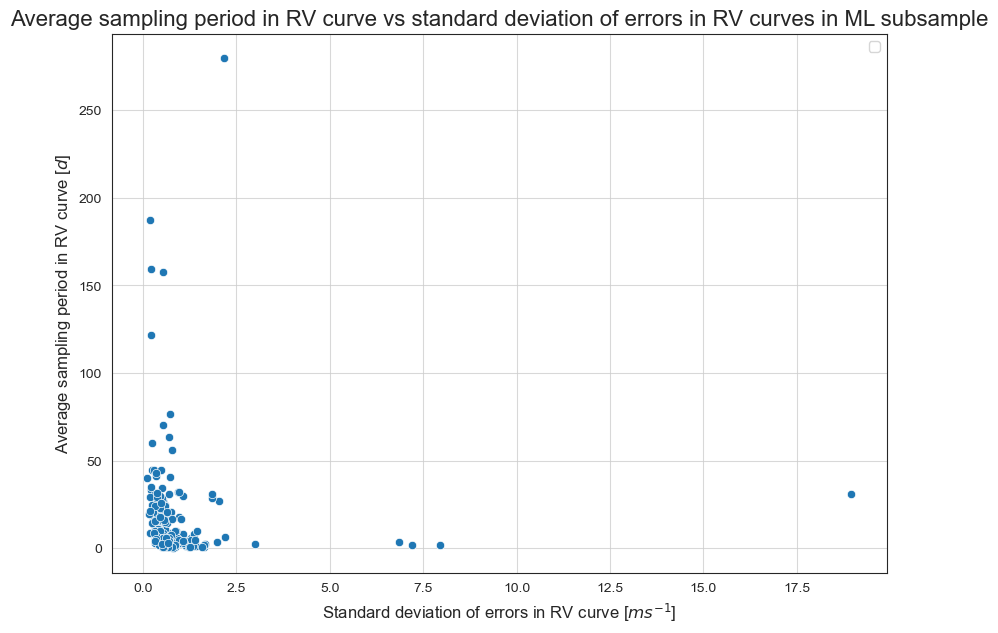

In [74]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_stdev', var_y='Ps_RV',
              fig_title="Average sampling period in RV curve vs standard deviation of errors in RV curves in ML subsample",
              x_label="Standard deviation of errors in RV curve [$ms^{-1}$]",
              y_label="Average sampling period in RV curve [$d$]",
              fig_filename=IMAGE_FOLDER + "SD_14_26_SamplingPeriod_vs_ErrorStdev.jpg")

**OBSERVATION:** no clear correlation is seen. The low Pearson's coefficient value confirms the conclusion.

####  Standard deviation of error vs RMS values in RV curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's correlation value: 0.158


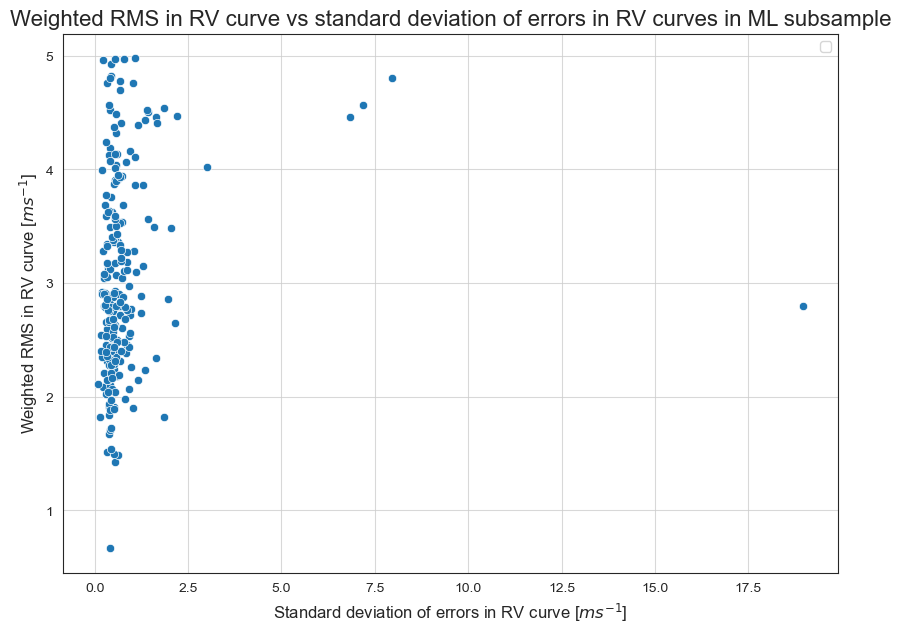

In [75]:
scatter_graph(data=rv_patterns,
              var_x='RV_noise_stdev', var_y='wrms_RV',
              fig_title="Weighted RMS in RV curve vs standard deviation of errors in RV curves in ML subsample",
              x_label="Standard deviation of errors in RV curve [$ms^{-1}$]",
              y_label="Weighted RMS in RV curve [$ms^{-1}$]",
              fig_filename=IMAGE_FOLDER + "SD_14_27_RVRMS_vs_ErrorStdev.jpg")

**OBSERVATION:** once again, no clear correlation is seen but the Pearson's coefficient value is slightly larger.

## Check the goodness of fit of noise distributions

We now check the goodness of fit for the nolise distributions created to simulate the noise values. We do this by checking the basic stats of the p-values obtained, and drawing a histogram of such value.

**NOTE:** this calculated p-value could conceivably be used as a weight for the random selection of the noise distribution tol be applied, favouring the selection of the distributions for the fit was estimated as better. 

In [76]:
print(list(rv_patterns['RV_noise_name'].unique()))

['t', 'lognorm', 'dweibull', 'genextreme', 'gamma', 'beta', 'expon', 'pareto']


### Check obtained p-values

In [77]:
rv_patterns['RV_noise_fit_p-value'].describe()

count    2.330000e+02
mean     5.050527e-01
std      2.783008e-01
min      5.690179e-18
25%      3.230119e-01
50%      5.401110e-01
75%      7.102133e-01
max      9.969537e-01
Name: RV_noise_fit_p-value, dtype: float64

All values seem pretty high (75% of the values are above $\approx0.3$), so it seems that the fitted distributions accurately mimic the mean noise values of their corresponding source data.

In [78]:
rv_patterns[['Karmn', 'n_RV', 'RV_noise_fit_p-value', 'RV_noise_name']] \
    .sort_values(by='RV_noise_fit_p-value', ascending=True)

,Karmn,n_RV,RV_noise_fit_p-value,RV_noise_name
170,J07274+052,768.0,5.690179e-18,dweibull
228,J00184+440,193.0,1.229232e-07,dweibull
207,J02530+168,253.0,5.765270e-04,t
127,J11054+435,117.0,9.060278e-03,t
53,J18165+048,46.0,9.593644e-03,dweibull
...,...,...,...,...
188,J05019-069,8.0,9.755884e-01,beta
137,J10238+438,5.0,9.782499e-01,dweibull
214,J02070+496,27.0,9.895829e-01,dweibull
58,J17578+046,622.0,9.957896e-01,genextreme


In [79]:
rv_patterns[['Karmn', 'n_RV', 'RV_noise_fit_p-value', 'RV_noise_name']] \
    .sort_values(by='n_RV', ascending=False)

,Karmn,n_RV,RV_noise_fit_p-value,RV_noise_name
170,J07274+052,768.0,5.690179e-18,dweibull
58,J17578+046,622.0,9.957896e-01,genextreme
9,J22565+165,549.0,4.590324e-01,genextreme
128,J11033+359,469.0,2.649168e-01,genextreme
1,J23492+024,373.0,4.903836e-01,lognorm
...,...,...,...,...
142,J09597+472,5.0,9.666293e-01,beta
197,J04219+213,4.0,1.370843e-01,gamma
199,J03473+086,4.0,4.530103e-01,genextreme
204,J03090+100,4.0,3.959895e-01,pareto


It seems that the goodness of fit is not related to the number of samples, as there is almost no coincidence between the top-5 and bottom-5 stars of both lists.

One interesting point, though, is the star _J07274+052_, which has the larger number of data points and the worst fit of all. It should be expected that with more data points the distibution fitting operation should have more information and the fit should be better, but that is not the case. The other three stars in the top-four (_J00184+440_, _J02530+168_ and _J11054+435_) have also a high number of data points with a low p-value, which also seems a little strange.

No handles with labels found to put in legend.


Pearson's correlation value: -0.056


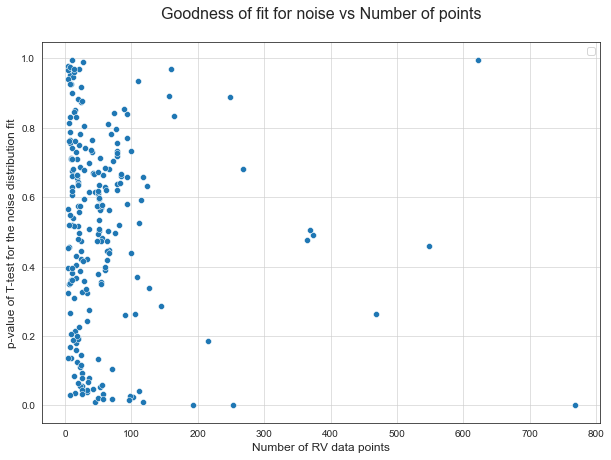

In [51]:
scatter_graph(data=rv_patterns,
              var_x='n_RV', var_y='RV_noise_fit_p-value',
              fig_title="Goodness of fit for noise vs Number of points\n",
              x_label="Number of RV data points",
              y_label="p-value of T-test for the noise distribution fit",
              fig_filename=IMAGE_FOLDER + "SD_14_28_NoiseFitGoodnes_vs_NumPoints.jpg")

**OBSERVATION:** Confirmed, there is no correlation.

count    2.330000e+02
mean     5.050527e-01
std      2.783008e-01
min      5.690179e-18
25%      3.230119e-01
50%      5.401110e-01
75%      7.102133e-01
max      9.969537e-01
Name: RV_noise_fit_p-value, dtype: float64
p = 3.25701e-07
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


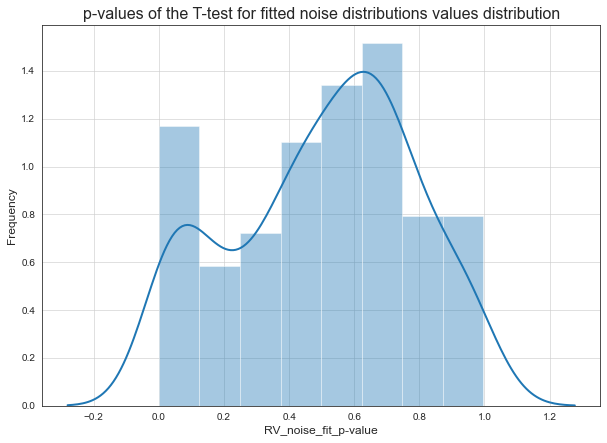

In [52]:
draw_hist(d1=rv_patterns['RV_noise_fit_p-value'], d1_label="p-values of the T-test for fitted noise distributions",
          fig_filename=IMAGE_FOLDER + "SD_14_29_NoiseFitGoodness_pvalue.jpg")

Let's see how the different types of distributions behave in terms of p-values.

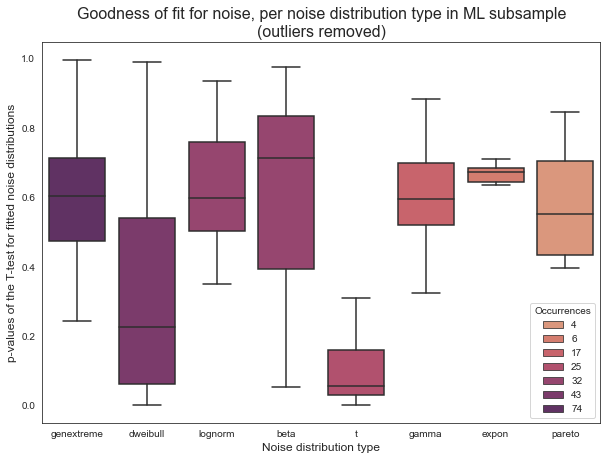

In [53]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='RV_noise_fit_p-value', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Goodness of fit for noise, per noise distribution type in ML subsample\n" \
             "(outliers removed)",
             x_label="Noise distribution type",
             y_label="p-values of the T-test for fitted noise distributions",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_30_NoiseFitGoodness_vs_NoiseDist.jpg")

It seems that t-distribution is the one which gets the worst fit. dweibull distribution, pretty common, also seems to have relatively low values for p-value, but in any case the values are high enough to suggest a good fit.

### Check the fraction of generated values that fall outside of the initial range

In [54]:
rv_patterns['Fraction_Out'].describe()

count    233.000000
mean       0.065643
std        0.102066
min        0.000000
25%        0.000000
50%        0.016667
75%        0.103448
max        0.714286
Name: Fraction_Out, dtype: float64

All values seem pretty low (75% of the values are below $\approx0.1$, i.e. $\approx10\%$), so it seems that the fitted distributions do not generate many points outside the initial range of errors.

No handles with labels found to put in legend.


Pearson's correlation value: -0.173


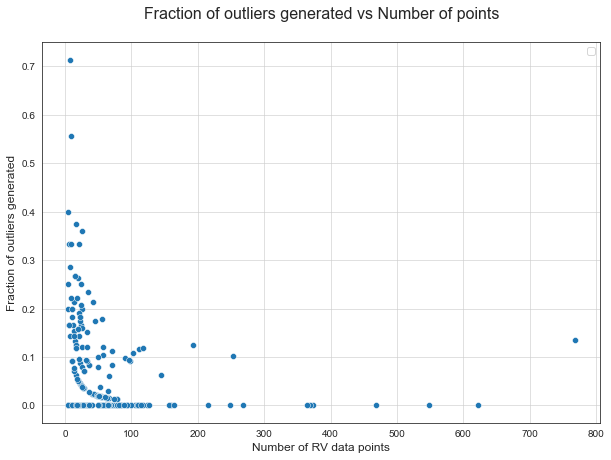

In [55]:
scatter_graph(data=rv_patterns,
              var_x='n_RV', var_y='Fraction_Out',
              fig_title="Fraction of outliers generated vs Number of points\n",
              x_label="Number of RV data points",
              y_label="Fraction of outliers generated",
              fig_filename=IMAGE_FOLDER + "SD_14_31_OutliersGenerated_vs_NumPoints.jpg")

It seems that for a lower number of data points, the fraction of outliers that tend to be generated by the fitted distributions tend to be higher.

count    233.000000
mean       0.065643
std        0.102066
min        0.000000
25%        0.000000
50%        0.016667
75%        0.103448
max        0.714286
Name: Fraction_Out, dtype: float64
p = 2.5292e-32
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


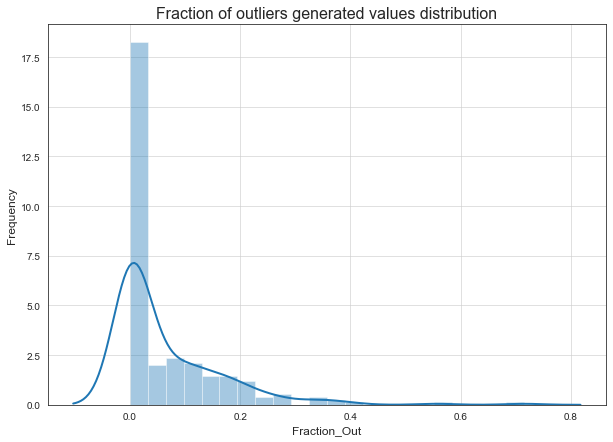

In [56]:
draw_hist(d1=rv_patterns['Fraction_Out'], d1_label="Fraction of outliers generated",
          fig_filename=IMAGE_FOLDER + "SD_14_32_NoiseFitGoodness_OutliersGenerated.jpg")

Let's see how the different types of distributions behave in terms of fraction of outliers generated.

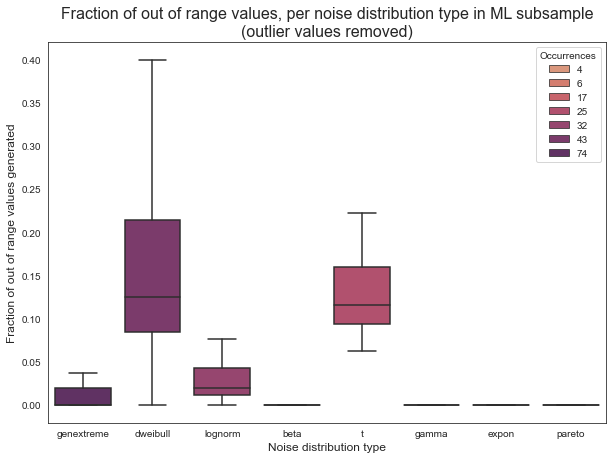

In [57]:
draw_boxplot(data=rv_patterns, x='RV_noise_name', y='Fraction_Out', hue='Occurrences', palette="flare",
             order=dist_order,
             fig_title="Fraction of out of range values, per noise distribution type in ML subsample\n" \
             "(outlier values removed)",
             x_label="Noise distribution type",
             y_label="Fraction of out of range values generated",
             showfliers=False,
             fig_filename=IMAGE_FOLDER + "SD_14_33_OutliersGenerated_vs_NoiseDist.jpg")

It seems that t-distribution and dweibull distributions are the more prone to randomly generate outliers. The values, though, are not extremely high, so we can cap the values to maximum or minimum original values when an outlier is generated without too much altering the noise nature.

## Summary

**CONCLUSIONS:**
- We have checked the correlation between the noise distribution type, mean and standard deviation on one side, versus star's radial velocity, number of RV data points on the other side:
  - In general, no correlation was observed at all.
  - The only exception is perhaps the correlation of `loc` value of the distributions ($\sim\;$mean) with the weighted RMS values of the RV curves, although the points in the scatter plot are much dispersed and the correlation value is not very high (0.432). 
- The lack of correlation between the noise distributions and some characteristics of the RV curves or even the observed object (in case of the reported radial velocity of the star) justify the independent use of the pools for sampling patterns and noise distributions for the generation os synthetic sample S4.
- We have also checked the goodness of fit for the different fitted noise distributions, seeing that in general the fits are pretty good ones. The calculated and stored p-value as a measure of the goodness of fit could conceivably be used later on as a weight value to influence the random selection of a noise distribution to generate the synthetic samples S2 and S4.
- Finally, we simulated the generation of random error values from each fitted distribution, checking how many of these values fell outside the original range of the error values in the source data. We found that the fraction was not high in any case, so we will cap the generated values to the maximum and minimum original values.